In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.svm import SVC, LinearSVC
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [3]:
from utils import load_dataset

# Load dataset

In [4]:
def calculate_cdf(series, num_points=1024):
    sorted_series = np.sort(series)
    cdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    sampled_points = np.linspace(np.min(sorted_series), np.max(sorted_series), num_points)
    sampled_cdf = np.interp(sampled_points, sorted_series, cdf)
    return sampled_cdf

In [5]:
def load_files(files, labels, max_len=None):
    data_arr = []
    final_labels = []
    
    for filepath, label in zip(files, labels):
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        cdf = calculate_cdf(x)

        data_arr.append(cdf)
        final_labels.append(label)
    
    return np.array(data_arr), np.array(final_labels)

In [6]:
nexmark_dataset = load_dataset.load_nexmark_data(is_split=False)

In [7]:
secure_sgx_dataset = load_dataset.load_secure_sgx_data_for_cross(is_split=False)

In [8]:
def get_data(data_files):
    files = []
    labels = []

    for operator in data_files:
        files.extend(data_files[operator]['files'])
        labels.extend([data_files[operator]['label']]*len(data_files[operator]['files']))


    data, labels = load_files(files, labels)

    return data, labels

In [9]:
nexmark_data, nexmark_labels = get_data(nexmark_dataset)

File ../nexmark_dataset/q2_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli.csv is empty.
File ../nexmark_dataset/q6_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli+292_filter_category_times_id_plus_seller_mod_duration_is_less_than_initialBid.csv is empty.


In [10]:
secure_sgx_data, secure_sgx_labels = get_data(secure_sgx_dataset)

In [11]:
from sklearn.metrics import accuracy_score

def evaluate(model, X_test, y_test, class_names):
    test_preds = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, test_preds)
    print(f"Accuracy: {accuracy:.4f}")

    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, labels=[0, 1, 4], digits=4))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    # ROC Curve
    y_score = model.predict_proba(X_test)
    plt.figure()

    # Confusion Matrix
    print("Confusion Matrix (Test):")
    cm = confusion_matrix(y_test, test_preds)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.figure()
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Random Forest

In [12]:
rf_nexmark = joblib.load('models/nexmark_rf.pkl')
rf_nexmark.best_params_

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 100}

Accuracy: 0.6107
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7446    0.3605    0.4858       380
           1     0.5558    0.8636    0.6763       352
           4     0.9967    0.6232    0.7669       483

   micro avg     0.7183    0.6107    0.6601      1215
   macro avg     0.7657    0.6158    0.6430      1215
weighted avg     0.7901    0.6107    0.6527      1215

Confusion Matrix (Test):
[[137 243   0   0   0   0]
 [ 47 304   0   0   1   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0 173   7 301   2]
 [  0   0   0   0   0   0]]
Confusion Matrix (Test):
[[137 243   0   0   0   0]
 [ 47 304   0   0   1   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0 173   7 301   2]
 [  0   0   0   0   0   0]]


/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

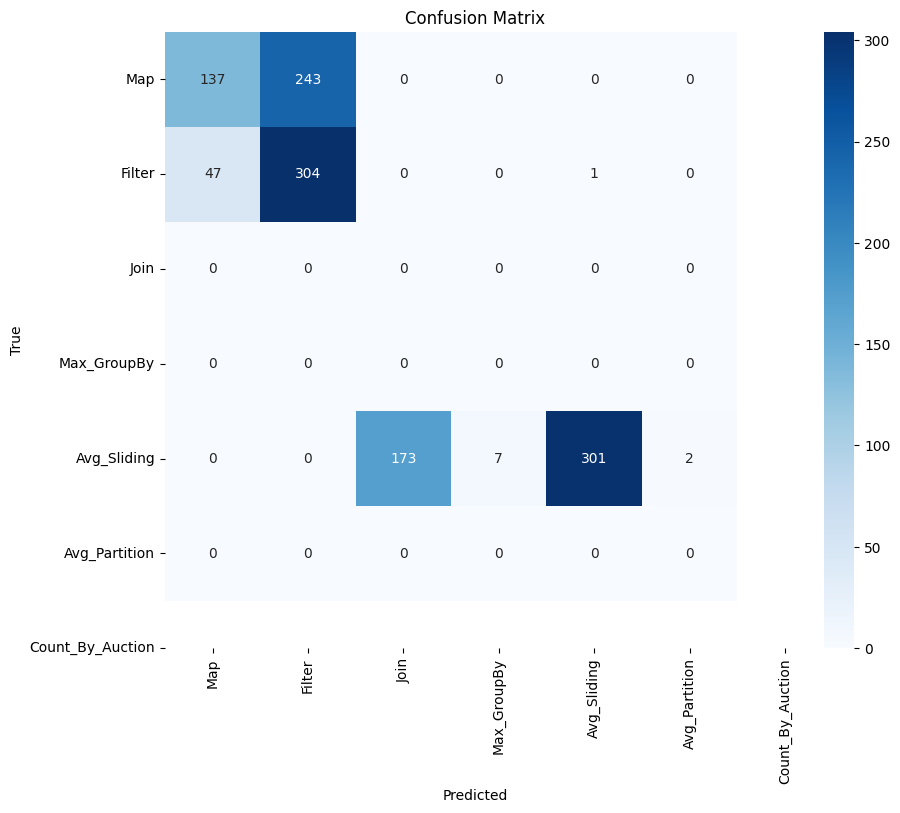

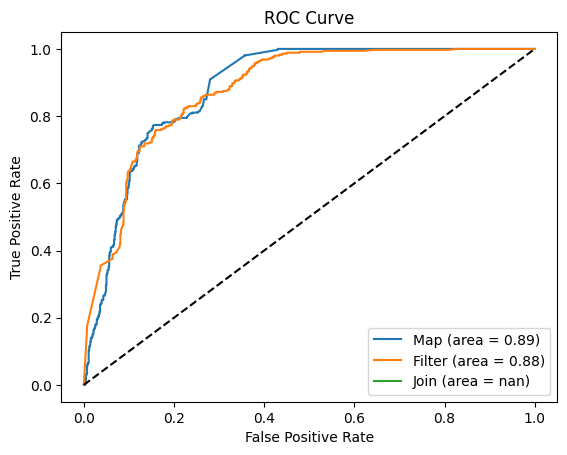

In [13]:
rf = RandomForestClassifier(**rf_nexmark.best_params_, n_jobs=-1, random_state=42)
rf.fit(nexmark_data, nexmark_labels)
evaluate(rf, secure_sgx_data, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

# SVM

In [16]:
svr_nexmark = joblib.load('models/nexmark_svr.pkl')
svr_nexmark.best_params_

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. Th

{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}

In [17]:
from sklearn.pipeline import Pipeline

# Define pipeline: scaler + SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=0.1, gamma=0.1, kernel='poly'))
])

pipeline.fit(nexmark_data, nexmark_labels)
evaluate(pipeline, secure_sgx_data, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)

Accuracy: 0.7169
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7097    0.4632    0.5605       380
           1     0.5800    0.7926    0.6699       352
           4     1.0000    0.8613    0.9255       483

   micro avg     0.7607    0.7169    0.7381      1215
   macro avg     0.7632    0.7057    0.7186      1215
weighted avg     0.7875    0.7169    0.7373      1215

Confusion Matrix (Test):
[[176 201   2   0   0   1   0]
 [ 72 279   1   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   1  62   3 416   0   1]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


AttributeError: This 'Pipeline' has no attribute 'predict_proba'

# XGB

In [18]:
xgb_nexmark = joblib.load('models/nexmark_xgb.pkl')
xgb_nexmark.best_params_

/home/bkcs/miniforge3/lib/python3.12/pickle.py:1760: UserWarning: [16:41:33] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'gamma': 0, 'max_depth': 6, 'n_estimators': 150}

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:41:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8008
Test Classification Report:
              precision    recall  f1-score   support

           0     0.7491    0.5737    0.6498       380
           1     0.6335    0.7955    0.7053       352
           4     0.9979    0.9834    0.9906       483

   micro avg     0.8048    0.8008    0.8028      1215
   macro avg     0.7935    0.7842    0.7819      1215
weighted avg     0.8145    0.8008    0.8014      1215

Confusion Matrix (Test):
[[218 162   0   0]
 [ 71 280   0   1]
 [  0   0   0   0]
 [  2   0   6 475]]
Confusion Matrix (Test):
[[218 162   0   0]
 [ 71 280   0   1]
 [  0   0   0   0]
 [  2   0   6 475]]


/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

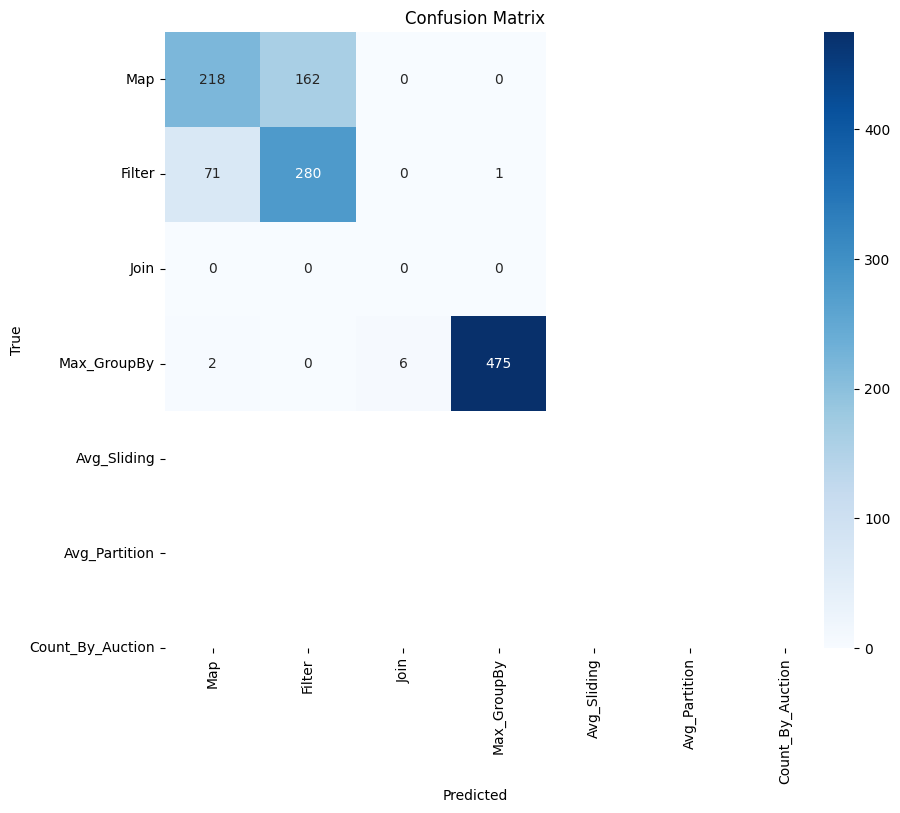

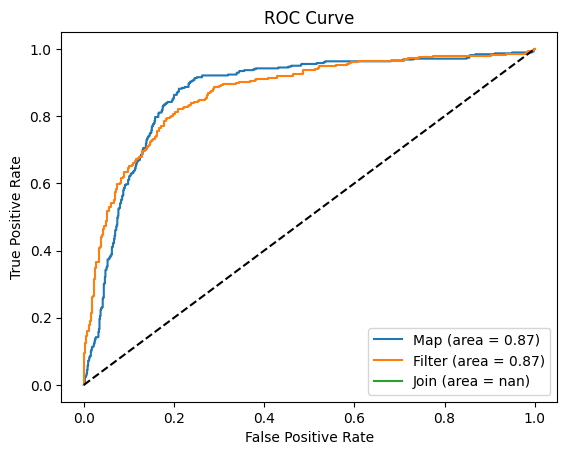

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_nexmark.best_params_, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(nexmark_data, nexmark_labels)
evaluate(xgb, secure_sgx_data, secure_sgx_labels, load_dataset.NEXMARK_CLASS_NAMES)